In [ ]:
%%capture
# Herramienta DBCV
!pip install "git+https://github.com/FelSiq/DBCV"
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

In [ ]:
from google.colab import files
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD


import cudf, cupy, cuml
from cuml.cluster import HDBSCAN
from cuml.manifold import UMAP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp, gc
from cuml.preprocessing import StandardScaler
import dbcv

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importar datos y crear Dataframe

In [ ]:
accidents_gdf = gdf = cudf.read_csv('/content/drive/MyDrive/Big Data/Proyecto Programado/US_Accidents_March23_sampled_500k.csv')
gdf.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,<NA>,<NA>,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.66118932,-120.4924419,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


In [ ]:
print(len(accidents_gdf))

500000


# Preprocesamiento

In [ ]:
accidents_gdf['Start_Time'] = pd.to_datetime(accidents_gdf['Start_Time'].to_pandas(), errors='coerce')
accidents_gdf['Start_Time'] = cudf.Series(accidents_gdf['Start_Time'])

accidents_gdf['Hour'] = accidents_gdf['Start_Time'].dt.hour
accidents_gdf['DayOfWeek'] = accidents_gdf['Start_Time'].dt.weekday
accidents_gdf['is_weekend'] = ((accidents_gdf['DayOfWeek'] >= 5).astype('int8'))

accidents_gdf['Sunrise_Sunset'] = accidents_gdf['Sunrise_Sunset'].fillna('Day')
accidents_gdf['is_night'] = (accidents_gdf['Sunrise_Sunset'] == 'Night').astype('int8')

weather = accidents_gdf['Weather_Condition'].str.lower().fillna('')
accidents_gdf['Rain'] = weather.str.contains('rain|storm|drizzle|shower').astype('int8')
accidents_gdf['Snow'] = weather.str.contains('snow|sleet|hail|ice').astype('int8')
accidents_gdf['Fog'] = weather.str.contains('fog|mist|haze|smoke').astype('int8')
accidents_gdf['Storm'] = weather.str.contains('thunderstorm|t-storm|storm').astype('int8')

for col in ['Junction', 'Traffic_Signal', 'Crossing', 'Stop']:
    accidents_gdf[col] = accidents_gdf[col].fillna(False).astype('int8')

accidents_gdf['Severity'] = accidents_gdf['Severity'].astype('int8')
accidents_gdf['Distance(mi)'] = accidents_gdf['Distance(mi)'].astype('float32').fillna(0.0)

In [ ]:
features = [
    'Severity', 'Distance(mi)',
    'Visibility(mi)', 'Precipitation(in)',
    'hour_sin', 'hour_cos',
    'is_weekend', 'is_night',
    'Junction', 'Traffic_Signal', 'Crossing', 'Stop',
    'Rain', 'Snow', 'Fog', 'Storm'
]

X_accidents = accidents_gdf[features].astype('float32').dropna()
print("Feature matrix shape:", X_accidents.shape)
print(X_accidents.head().to_pandas())

Feature matrix shape: (309374, 16)
   Severity  Distance(mi)  Visibility(mi)  Precipitation(in)  hour_sin  \
0       2.0         0.000            10.0                0.0  0.500000   
3       2.0         1.054            10.0                0.0 -0.965926   
4       2.0         0.046            10.0                0.0  0.258819   
5       2.0         0.000            10.0                0.0  0.965926   
6       2.0         0.000            10.0                0.0 -0.866025   

   hour_cos  is_weekend  is_night  Junction  Traffic_Signal  Crossing  Stop  \
0 -0.866026         0.0       0.0       0.0             1.0       0.0   0.0   
3 -0.258819         0.0       0.0       0.0             0.0       0.0   0.0   
4  0.965926         0.0       1.0       0.0             0.0       0.0   0.0   
5 -0.258819         0.0       0.0       0.0             1.0       0.0   0.0   
6 -0.500000         0.0       0.0       0.0             0.0       0.0   0.0   

   Rain  Snow  Fog  Storm  
0   0.0   0.0  0.

In [ ]:
continuous_cols = ['Distance(mi)', 'Visibility(mi)', 'Precipitation(in)']
scaler = StandardScaler()
X_accidents[continuous_cols] = scaler.fit_transform(X_accidents[continuous_cols])
X_accidents['Severity'] = X_accidents['Severity'] / 4.0

X_accidents.describe()

,Severity,Distance(mi),Visibility(mi),Precipitation(in),hour_sin,hour_cos,is_weekend,is_night,Junction,Traffic_Signal,Crossing,Stop,Rain,Snow,Fog,Storm
count,309374.000000,191920.000000,191920.000000,191920.000000,309374.000000,309374.000000,309374.000000,309374.000000,309374.000000,309374.000000,309374.000000,309374.000000,309374.000000,309374.000000,309374.000000,309374.000000
mean,0.135809,0.000788,-0.002788,0.001779,-0.061631,-0.261275,0.171824,0.321375,0.069825,0.137862,0.109553,0.027927,0.102174,0.027019,0.028034,0.007050
std,0.029101,1.008678,0.995449,1.003617,0.758015,0.594435,0.377228,0.467005,0.254852,0.344756,0.312333,0.164765,0.302878,0.162139,0.165070,0.083666
min,0.062500,-0.334590,-3.293991,-0.087422,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125000,-0.334590,0.393941,-0.087422,-0.866025,-0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.125000,-0.303643,0.393941,-0.087422,-0.258819,-0.258819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.125000,-0.046125,0.393941,-0.087422,0.866025,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.250000,82.386200,26.209467,105.463898,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X_accidents = X_accidents.sample(n = 50000, random_state=42)
print("Cantidad de datos: ", len(accidents_gdf))

Cantidad de datos:  500000


In [ ]:
X_accidents = X_accidents.dropna()

umap5 = UMAP(n_components=5, n_neighbors=30, min_dist=0.0, random_state=42)
X_accidents_5d = umap5.fit_transform(X_accidents)

umap2 = UMAP(n_components=2, n_neighbors=30, min_dist=0.0, random_state=42)
X_accidents_2d = umap2.fit_transform(X_accidents)

print(X_accidents_5d.shape, X_accidents_2d.shape)

[2025-06-27 16:27:56.287] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2025-06-27 16:27:56.595] [CUML] [info] build_algo set to brute_force_knn because random_state is given
(50000, 5) (50000, 2)


In [ ]:
min_cluster_sizes = [200, 225, 250, 275, 300]
grid_results = []

for min_cluster_size in min_cluster_sizes:
      clusterer = HDBSCAN(min_cluster_size=min_cluster_size)
      clusterer_labels = clusterer.fit_predict(X_accidents_5d)

      cp = clusterer_labels.to_numpy()

      n_clusters = len(set(cp)) - (1 if -1 in cp else 0)
      if n_clusters < 2:
          continue

      score = dbcv.dbcv(X_accidents_5d.to_numpy(), cp)


      grid_results.append({
          "min_cluster_size": min_cluster_size,
          "n_clusters": n_clusters,
          "DBCV": score
      })

results_df = pd.DataFrame(grid_results)
results_df = results_df.sort_values(by="DBCV", ascending=False)
results_df.reset_index(drop=True, inplace=True)

results_df.head()

In [ ]:
clusterer = HDBSCAN(min_cluster_size=225)
clusterer_labels = clusterer.fit_predict(X_accidents_5d)

In [ ]:
score = dbcv.dbcv(X_accidents_5d.to_numpy(), clusterer_labels.to_numpy())
print(f"DBCV Score:{score:.3f}")

DBCV Score:0.278


In [ ]:
labels = clusterer_labels
n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
noise_count = np.sum(labels == -1)
print(f"HDBSCAN identified {n_clusters} clusters")

HDBSCAN identified 7 clusters


In [ ]:
labels_series = cudf.Series(labels)
cluster_counts = labels_series.value_counts().sort_index().to_pandas()
print(cluster_counts)

-1     2913
 0      291
 1      250
 2      286
 3      365
 4    26653
 5      278
Name: count, dtype: int64


In [ ]:
gdf['Cluster'] = labels_series

pdf = gdf.to_pandas()[['Severity','Start_Time','State','Weather_Condition',
                       'is_night','is_weekend','Rain','Snow','Fog','Storm',
                       'Junction','Traffic_Signal','Crossing','Stop','Cluster']]

In [ ]:
cluster_sizes = pdf['Cluster'].value_counts().sort_index()
print("Cluster sizes:\n", cluster_sizes)

Cluster sizes:
 Cluster
-1.0     2913
 0.0      291
 1.0      250
 2.0      286
 3.0      365
 4.0    26653
 5.0      278
Name: count, dtype: int64


In [ ]:
cluster_profiles = pdf[pdf['Cluster']!=-1].groupby('Cluster').agg({
    'Severity': 'mean',
    'is_night': 'mean',
    'is_weekend': 'mean',
    'Rain': 'mean',
    'Snow': 'mean',
    'Fog': 'mean',
    'Storm': 'mean',
    'Junction': 'mean',
    'Traffic_Signal': 'mean',
    'Crossing': 'mean',
    'Stop': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster':'Count'})

print(cluster_profiles)

         Severity  is_night  is_weekend      Rain      Snow       Fog  \
Cluster                                                                 
0.0      2.140893  0.000000    0.000000  0.000000  0.000000  0.000000   
1.0      2.000000  0.004000    0.000000  0.000000  0.000000  0.000000   
2.0      1.996503  0.083916    0.000000  0.000000  0.000000  0.000000   
3.0      2.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
4.0      2.187521  0.333696    0.184144  0.119799  0.031178  0.033992   
5.0      2.000000  0.000000    0.000000  0.000000  0.000000  0.000000   

            Storm  Junction  Traffic_Signal  Crossing      Stop  Count  
Cluster                                                                 
0.0      0.000000  0.000000         0.00000  0.000000  0.000000    291  
1.0      0.000000  0.000000         0.00000  0.000000  0.000000    250  
2.0      0.000000  0.000000         0.00000  0.000000  0.000000    286  
3.0      0.000000  0.000000         0.00000  0.000

/tmp/ipython-input-26-1534825390.py:9: RuntimeWarning: invalid value encountered in divide
  pct = counts / counts.sum() * 100


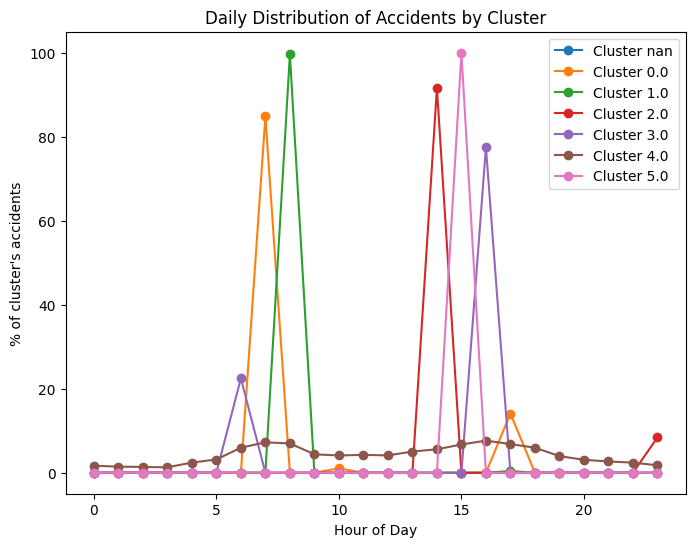

In [ ]:
hours = pd.DatetimeIndex(pdf['Start_Time']).hour
plt.figure(figsize=(8,6))
for c in sorted(pdf['Cluster'].unique()):
    if c == -1:
        continue

    cluster_hours = hours[pdf['Cluster']==c]
    counts, bins = np.histogram(cluster_hours, bins=24, range=(0,24))
    pct = counts / counts.sum() * 100
    plt.plot(bins[:-1], pct, marker='o', label=f"Cluster {c}")
plt.xlabel("Hour of Day")
plt.ylabel("% of cluster's accidents")
plt.title("Daily Distribution of Accidents by Cluster")
plt.legend()
plt.show()

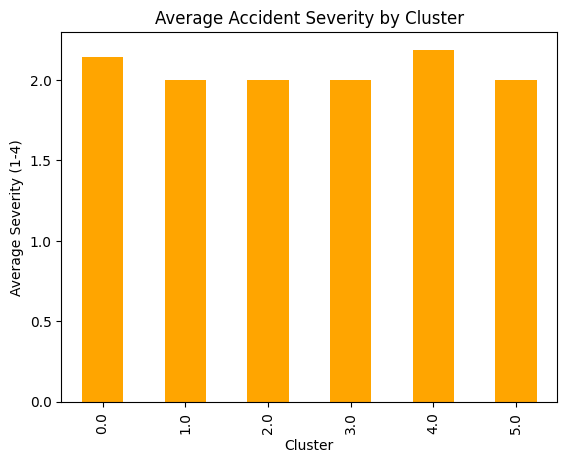

In [ ]:
avg_sev = pdf[pdf['Cluster']!=-1].groupby('Cluster')['Severity'].mean()
avg_sev.plot(kind='bar', color='orange')
plt.ylabel("Average Severity (1-4)")
plt.title("Average Accident Severity by Cluster")
plt.show()